In [1]:
import sys
# setting path
sys.path.append('../')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from argparse import ArgumentParser

from Benchmarks.Models.BenchmarkCaller import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from tqdm import trange, tqdm
import itertools
from scipy.stats import mode


## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))       

In [2]:
def CompResource (PredModel, Data, BatchSize=1, GPU=True):  # GPU vs CPU

    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)
    else:
        PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)

    return PredVal

# Power spectral density 
def FFT_PSD (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    # (NMiniBat, NGen, SigDim)
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (NMiniBat, NGen, N_frequency)
    PSD = (FFTRes**2)/Data.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis =='Sample':
        AggPSD = np.mean(PSD, axis=(1))
        # (NMiniBat, N_frequency)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis == 'None':
        # (NMiniBat, NGen, N_frequency)
        AggPSPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSPDF


# Permutation given PSD over each generation
def ProbPermutation(Data, WindowSize=3):
    # For the M generation vectors, Data shape: (NMiniBat, N_frequency, NGen)
    # For the true PSD, Data shape: (1, N_frequency, NMiniBat)
    
    # Generating true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(WindowSize)))).reshape(-1, WindowSize)

    # Getting all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=WindowSize, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None,None] == PermsTable[:,:,:, None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    # Reducing the window axis
    CountPerms = np.sum(CountPerms, axis=(2))
    
    # Data shape: (NMiniBat, N_frequency, N_permutation_cases)
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, 1e-7)    



def MeanKLD(P,Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=-1))



def Sampler (Data, SampModel,BatchSize=100, GPU=True):
    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   
    else:
        PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   

    return PredVal



def SamplingZ (Data, SampModel, NMiniBat, NGen, BatchSize = 1000, GPU=True, SampZType='GaussBRpt', SecDataType=None, ReparaStdZj=1.):
    
    '''
    Sampling Samp_Z 

    - Shape of UniqSamp_Z: (NMiniBat, LatDim)
    - UniqSamp_Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ) for Type =='Model*'
    - UniqSamp_Z ~ N(Zμ|y, cond, σ) for Type =='Model*' and when there are ancillary (i.e., Conditional VAE) data inputs 
    - RandSamp_Z ~ N(0, ReparaStdZj) for Type =='Gauss*'

    - Samp_Z is a 3D tensor expanded by repeating the first axis (i.e., 0) of UniqSamp_Z or RandSamp_Z by NGen times.
    - Shape of Samp_Z: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
    
    - ModelBRpt:  The predicted values are repeated NGen times after the prediction. 
                  It is strongly recommended in cases where there are variations in the ancillary data inputs.  
    - ModelARand: The data is repeated NGen times before the prediction (i.e., All random sampling).
                  It is strongly recommended when there is no ancillary data inputs or variations in the ancillary data.     
    - Gauss:      The data is sampled NMiniBat*NGen times. 
                  It is recommended to detect the influence of changes in the value of j on the performance metrics, 
                  when the same ancillary data input is repeated NGen times (i.e., for Conditional VAE).
    - GaussBRpt:  The data sampled from the Gaussian distribution is repeated NGen times.
                  It is recommended for both cases: when there are no ancillary data inputs and when there is ancillary data input.
                  
    '''
    assert SampZType in ['ModelBRpt','ModelARand','Gauss', 'GaussBRpt'], "Please verify the value of 'SampZType'. Only 'ModelBRpt','ModelARand','Gauss', 'GaussBRpt' are valid."
    
    # Sampling Samp_Z
    if SampZType =='ModelBRpt': # Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ) 
        UniqSamp_Z = Sampler(Data, SampModel, GPU=GPU)
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, None], (NMiniBat, NGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
    
    elif SampZType =='ModelARand': # Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ)
        
        if SecDataType == 'CONDIN' : # For the CondVAE
            DataRpt = [np.repeat(arr, NGen, axis=0) for arr in Data]
        else:
            DataRpt = np.repeat(Data, NGen, axis=0)
        Samp_Z = Sampler(DataRpt, SampModel, GPU=GPU)
        
    elif SampZType =='Gauss': # Z ~ N(0, ReparaStdZj)
        Samp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat*NGen , SampModel.output.shape[-1]))
        
    elif SampZType =='GaussBRpt': # Z ~ N(0, ReparaStdZj)
        UniqSamp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat , SampModel.output.shape[-1]))
        Samp_Z = np.repeat(UniqSamp_Z, NGen, axis=0)
    
    return Samp_Z



def SamplingZj (Samp_Z, NMiniBat, NGen, LatDim, NSelZ, ZjType='ARand' ):
    
    '''
     Sampling Samp_Zj 

    - Masking is applied to select Samp_Zj from Samp_Z 
      by assuming that the Samp_Z with indices other than j have a fixed mean value of '0' following a Gaussian distribution.

    - Shape of Samp_Zj: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 

    - Samp_Zj ~ N(Zμj|y, σj), j∼U(1,LatDim)
    - In the expression j∼U(1,LatDim), j corresponds to LatDim and all js are selected randomly.

    '''
    
    # Masking for selecting Samp_Zj from Samp_Z 
    if ZjType =='ARand': #It is strongly recommended when there is no ancillary data inputs or variations in the ancillary data.
        Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
        for i in range(NMiniBat*NGen):
            Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            
    elif ZjType =='BRpt': # It is strongly recommended in cases where there are variations in ancillary data inputs.
        Mask_Z = np.zeros((NMiniBat, NGen, LatDim))
        for i in range(NMiniBat):
            Mask_Z[i, :, np.random.choice(LatDim, NSelZ,replace=False )] = 1
    
    # Selecting Samp_Zj from Samp_Z 
    Mask_Z = Mask_Z.reshape(NMiniBat*NGen, LatDim)
    Samp_Zj = Samp_Z * Mask_Z
    
    return Samp_Zj




In [3]:
YamlPath = './Config/EvalConfigART.yml'
ModelConfigs = ReadYaml(YamlPath)
[i for i in ModelConfigs]

['Common_Info',
 'BaseVAE_ART_30',
 'BaseVAE_ART_50',
 'FACVAE_ART_30',
 'FACVAE_ART_50',
 'ConVAE_ART_30',
 'ConVAE_ART_50',
 'TCVAE_ART_30',
 'TCVAE_ART_50']

In [4]:
ConfigName = 'ConVAE_ART_50'
YamlPath = './Config/EvalConfigART.yml'
EvalConfigs = ReadYaml(YamlPath)

# Loading the model configurations
ModelConfigSet, ModelLoadPath = LoadModelConfigs(ConfigName, Comp=False)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']


# Object Load path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'.pkl'
SampZjLoadPath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'


In [5]:
# Loading data
TrData = np.load('../Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
VallData = np.load('../Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')

# Intermediate parameters 
SigDim = VallData.shape[1]
DataSize = VallData.shape[0]

In [88]:
class Evaluator ():
    
    def __init__ (self, MinFreq=1, MaxFreq=51,  SimSize = 1, NMiniBat=100,  NGen=100, ReparaStdZj = 1, NSelZ = 1, 
                  SampBatchSize = 1000, GenBatchSize = 1000, SelMetricCut = 1., SelMetricType = 'KLD', GPU=True, Name=None):

        
        # Optional parameters with default values
        self.MinFreq = MinFreq               # The minimum frequency value within the analysis range (default = 1).
        self.MaxFreq = MaxFreq               # The maximum frequency value within the analysis range (default = 51).
        self.SimSize = SimSize               # Then umber of simulation repetitions for aggregating metrics (default: 1)
        self.NMiniBat = NMiniBat             # The size of the mini-batch, splitting the task into N pieces of size NMiniBat.
        self.NGen = NGen                     # The number of generations (i.e., samplings) within the mini-batch.
        self.ReparaStdZj = ReparaStdZj       # The size of the standard deviation when sampling Zj (Samp_Zjb ~ N(0, ReparaStdZj)).
        self.NSelZ = NSelZ                   # The size of js to be selected at the same time (default: 1).
        self.SampBatchSize = SampBatchSize   # The batch size during prediction of the sampling model.
        self.GenBatchSize= GenBatchSize      # The batch size during prediction of the generation model.
        self.GPU = GPU                       # GPU vs CPU during model predictions (i.e., for SampModel and GenModel).
        self.SelMetricCut = SelMetricCut     # The threshold for Zs and ancillary data where the metric value is below SelMetricCut.
        self.SelMetricType = SelMetricType   # The type of metric used for selecting Zs and ancillary data. 
        self.Name = Name                     # Model name.

    
    
    ''' ------------------------------------------------------ Ancillary Functions ------------------------------------------------------'''

    ### ----------- Searching for candidate Zj for plausible signal generation ----------- ###
    def LocCandZsMaxFreq (self, CandQV, Samp_Z, SecData=None):
        # Shape of CandQV: (NMiniBat, N_frequency, NGen)
        # Shape of Samp_Z: (NMiniBat x NGen, LatDim)
        # Shape of SecData: (NMiniBat x NGen, SecDataDim)

        
        if self.SelMetricType == 'Entropy': 
            # Calculating the entropies given the probability density function of the power spectral.
            ## Return shape: (NMiniBat x NGen )
            Score = -np.sum(CandQV * np.log(CandQV), axis=1).ravel()
    
        elif self.SelMetricType == 'KLD':
            # Calculating KLD(QV_Batch||CandQV_T) (KLD_BatGen) and selecing IDs for which KLD_BatGen less than SelMetricCut.
            ## Shape of CandQV_T: (NMiniBat, N_frequency, NGen) -> (NMiniBat x NGen, N_frequency, 1), Shape of QV_Batch: (1, N_frequency, NMiniBat)
            CandQV_T = CandQV.transpose(0,2,1).reshape(self.NMiniBat*self.NGen, -1)[:,:,None]
            KLD_BatGen = np.sum(self.QV_Batch * np.log(self.QV_Batch / CandQV_T ), axis=1)
        
            ## Return shape: (NMiniBat x NGen )
            Score = np.min(KLD_BatGen, axis=-1)

        
        # Getting the maximum frequency given the PSD from CandQV.
        ## The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        ## Return shape: (NMiniBat, NGen) -> (NMiniBat x NGen) for the computational efficiency (i.e, ravel function applied)
        MaxFreq = np.argmax(CandQV, axis=1).ravel() + 1

        for Freq, _ in self.BestZsMetrics.items():
            FreqIdx = np.where(MaxFreq == Freq)[0]

            # Skipping the remainder of the code if there are no FreqIdx present at the predefined frequencies.
            if len(FreqIdx) <1: 
                continue;

            # Calculating the minimum of Score and selecting candidate Z-values(CandZs)
            MinScoreIdx = np.argmin(Score[FreqIdx]) 
            MinScore = np.min(Score[FreqIdx]) 
            CandZs = Samp_Z[[FreqIdx[MinScoreIdx]]]
            
            # Tracking results
            self.TrackerCand_Temp[Freq]['TrackZs'].append(CandZs[None])
            self.TrackerCand_Temp[Freq]['TrackMetrics'].append(MinScore[None])
            
            if SecData is not None: # for processing secondary data (SecData).
                CandSecData = SecData[[FreqIdx[MinScoreIdx]]]
                self.TrackerCand_Temp[Freq]['TrackSecData'].append(CandSecData[None])
            else:
                CandSecData = None

            # Updating the Min_SumH value if the current iteration value is smaller.
            if MinScore < self.BestZsMetrics[Freq][0]:
                self.BestZsMetrics[Freq] = [MinScore, CandZs, CandSecData]
                print('Candidate Z updated! ', 'Freq:', Freq, ', Score:', np.round(MinScore, 4))


    
    ### ------------------------  # Selecting nested Z values and secondary data matrix --------------------- ###
    def SubNestedZFix(self, SubTrackerCand):
                
        ''' Constructing the dictionary: {'KeyID': { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}
           
           - Outer Dictionary:
             - Key (KeyID): A unique, sequentially increasing integer from 'Cnt'; That is, the sequence number in each frequency domain.
             - Value: An inner dictionary (explained below)
        
           - Inner Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
        '''
        
        Cnt = itertools.count()
        if self.SecDataType == False:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs} 
                        for TrackZs, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }

        else:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs, 'TrackSecData' : TrackSecData} 
                        for TrackZs, TrackSecData, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackSecData'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }
            
        return Results
    
    
    
    ### ------------------------------ Conducting task iteration ------------------------------ ###
    def Iteration (self, TaskLogic):

        # Just functional code for setting the initial position of the progress bar 
        self.StartBarPoint = self.TotalIterSize*(self.iter/self.TotalIterSize) 
        with trange(self.iter, self.TotalIterSize , initial=self.StartBarPoint, leave=False) as t:

            for sim in range(self.sim, self.SimSize):
                self.sim = sim

                # Check the types of ancillary data fed into the sampler model and define the pipeline accordingly.
                if self.SecDataType == 'CONDIN' : 
                    SplitData = [np.array_split(sub, self.SubIterSize) for sub in (self.AnalSig, self.TrueCond)] 

                else: # For models with a single input such as VAE and TCVAE.
                    SplitData = np.array_split(self.AnalSig, self.SubIterSize)    

                for mini in range(self.mini, self.SubIterSize):
                    self.mini = mini
                    self.iter += 1
                    print()

                    # Core part; the task logic as the function
                    if self.SecDataType  == 'CONDIN': 
                        TaskLogic([subs[mini] for subs in SplitData])
                    else:
                        TaskLogic(SplitData[mini])

                    t.update(1)
    
    
    
    ### ------------------- Selecting post-sampled Z values for generating plausible signals ------------------- ###
    def SelPostSamp (self, SelMetricCut=np.inf, BestZsMetrics=None, TrackerCand=None, SavePath=None ):
        
        ## Optional parameters
        # Updating The threshold value for selecting Zs in SubNestedZFix if needed.
        self.SelMetricCut = SelMetricCut

        # Setting arguments
        BestZsMetrics = self.BestZsMetrics if BestZsMetrics is None else BestZsMetrics
        TrackerCand = self.TrackerCand if TrackerCand is None else TrackerCand
                
        # Exploring FreqIDs available for signal generation  
        ## FreqIDs such as [9, 10, 11 ..... 45]
        ## item[0] contains frequency domains
        ## item[1][0] contains metrics
        self.CandFreqIDs = [item[0] for item in BestZsMetrics.items() if item[1][0] != np.inf ]
            
        
        # Selecting nested Z values and secondary data matrix
        '''  Constructing the dictionary : {'FreqID' : {'SubKeys' : { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}}
        
           - Outermost Dictionary:
             - Key (FreqID): Represents frequency identifiers.
             - Value: A second-level dictionary (explained below).
        
           - Second-level Dictionary:
             - Key (SubKeys): Represents sub-key (i.e., ID) for the given 'FreqID'.
             - Value: A third-level dictionary (explained below).
        
           - Third-level Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
             
        '''
        self.PostSamp = {FreqID : self.SubNestedZFix(TrackerCand[FreqID], ) for FreqID in self.CandFreqIDs}

        
        
        # Counting the number of obs in NestedZs
        NPostZs =0 
        for item in self.PostSamp.items():
            NPostZs += len(item[1])

        print('The total number of sets in NestedZs:', NPostZs)

        
        return self.PostSamp
    
    
        
    ### -------------- Evaluating the KLD between the PSD of the true signals and the generated signals ---------------- ###
    def KLD_TrueGen (self, PostSamp=None, AnalSig=None, SecDataType=None, PlotDist=True):
    
        ## Required parameters
        # PostSamp: The post-sampled data for generating signals with the shape of ({'FreqID': {'SubKeys': {'TrackZs': Zs, 'TrackSecData': Secondary-data}}}).
        # AnalSig: The raw true signals for obtaining the population PSD.    
        
        ## Optional parameters
        # SecDataType: The ancillary data-type: Use 'FCIN' for FC values or 'CONDIN' for conditional inputs such as power spectral density.
        # PostSamp: The selected sampled data.

        
        # Setting arguments
        PostSamp = self.PostSamp if PostSamp is None else PostSamp
        AnalSig = self.AnalSig if AnalSig is None else AnalSig
        SecDataType = self.SecDataType if SecDataType is None else SecDataType
        
        # Converting the dictionary to the list type.
        PostZsList = []
        PostSecDataList = []

        for Freq, Subkeys in PostSamp.items():
            for Subkeys, Values in Subkeys.items():
                PostZsList.append(np.array(Values['TrackZs']))
                if 'TrackSecData' in Values.keys(): 
                    PostSecDataList.append(np.array(Values['TrackSecData']))
        
        # Converting the list type to the np-data type.
        PostZsList = np.concatenate(PostZsList)
        if SecDataType is not False:  # it means there are secondary-data inputs
            PostSecDataList = np.concatenate(PostSecDataList)
        
        
        # Data binding for the model input
        if SecDataType == 'FCIN':
            Data = [PostSecDataList[:, :2], PostSecDataList[:, 2:], PostZsList]
        elif SecDataType == 'CONDIN':  
             Data = [PostZsList, PostSecDataList]
        elif SecDataType == False :
             Data = PostZsList
            
          
        # Generating signals
        self.GenSamp = CompResource (self.GenModel, Data, BatchSize=self.GenBatchSize, GPU=self.GPU)
            

        # Calculating the KLD between the PSD of the true signals and the generated signals    
        PSDGenSamp =  FFT_PSD(self.GenSamp, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
        PSDTrueData =  FFT_PSD(AnalSig, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
            
            
        self.KldPSD_GenTrue = MeanKLD(PSDGenSamp, PSDTrueData)
        self.KldPSD_TrueGen  = MeanKLD(PSDTrueData, PSDGenSamp)
        self.MeanKld_GTTG = (self.KldPSD_GenTrue + self.KldPSD_TrueGen) / 2
        

        print('KldPSD_GenTrue: ', self.KldPSD_GenTrue)
        print('KldPSD_TrueGen: ', self.KldPSD_TrueGen)
        print('MeanKld_GTTG: ', self.MeanKld_GTTG)

        if PlotDist==True:
            plt.plot(PSDGenSamp, c='green', label='Generated')
            plt.plot(PSDTrueData, c='orange', label='True')
            plt.fill_between(np.arange(len(PSDTrueData)), PSDTrueData, color='orange', alpha=0.5)
            plt.fill_between(np.arange(len(PSDGenSamp)), PSDGenSamp, color='green', alpha=0.5)
            plt.legend()    



    
    ### -------------------------- Evaluating the performance of the model using both Z and Conditions -------------------------- ###
    def Eval_ZCON (self, AnalData, SampModel, GenModel, FcLimit=0.05,  WindowSize=3,  SecDataType=None,  Continue=True ):
        
        ## Required parameters
        self.SampModel = SampModel           # The model that samples Zs.
        self.GenModel = GenModel             # The model that generates signals based on given Zs and Cons.
        
        assert SecDataType in ['FCIN','CONDIN', False], "Please verify the value of 'SecDataType'. Only 'FCIN', 'CONDIN'  or False are valid."
        
        
        
        ## Optional parameters with default values ##
        # WindowSize: The window size when calculating the permutation sets (default: 3).
        # Continue: Start from the beginning (Continue = False) vs. Continue where left off (Continue = True).
        self.SecDataType = SecDataType   # The ancillary data-type: Use 'FCIN' for FC values or 'CONDIN' for conditional inputs such as power spectral density.
        
        

        ## Intermediate variables
        self.AnalSig = AnalData[0]  # The raw true signals to be used for analysis.
        self.TrueCond = AnalData[1] # The raw true PSD to be used for analysis.
        self.Ndata = len(self.AnalSig) # The dimension size of the data.
        self.LatDim = SampModel.output.shape[-1] # The dimension size of Z.
        self.SigDim =  self.AnalSig.shape[-1] # The dimension (i.e., length) size of the raw signal.
        self.CondDim = self.TrueCond.shape[-1] # The dimension size of the conditional inputs.
        self.SubIterSize = self.Ndata//self.NMiniBat
        self.TotalIterSize = self.SubIterSize * self.SimSize
        
        assert self.NGen >= self.CondDim, "NGen must be greater than or equal to CondDim for the evaluation."

        
        # Functional trackers
        if Continue == False or not hasattr(self, 'iter'):
            self.sim, self.mini, self.iter = 0, 0, 0
        
            ## Result trackers
            self.SubResDic = {'I_V_Z':[],'I_V_ZjZ':[],'I_V_Zj':[],'I_V_CONsZj':[],'I_S_Zj':[],'I_S_CONsZj':[]}
            self.AggResDic = {'I_V_Z':[],'I_V_ZjZ':[],'I_V_Zj':[],'I_V_CONsZj':[],'I_S_Zj':[],'I_S_CONsZj':[], 
                         'MI_V_ZjZ':[], 'MI_V_CONsZj':[], 'MI_S_CONsZj':[]}
            self.BestZsMetrics = {i:[np.inf] for i in range(1, self.MaxFreq - self.MinFreq + 2)}
            self.TrackerCand_Temp = {i:{'TrackSecData':[],'TrackZs':[],'TrackMetrics':[] } for i in range(1, self.MaxFreq - self.MinFreq + 2)} 
            self.I_V_Z, self.I_V_ZjZ, self.I_V_Zj, self.I_V_CONsZj, self.I_S_Zj, self.I_S_CONsZj = 0,0,0,0,0,0
        
         

        
        ### ------------------------------------------------ Task logics ------------------------------------------------ ###
        
        # P(V=v)
        ## Data shape: (N_frequency)
        self.QV_Pop = FFT_PSD(self.AnalSig, 'All', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
        
        
        def TaskLogic(SubData):

            ### ------------------------------------------------ Sampling ------------------------------------------------ ###
            # Updating NMiniBat; If there is a remainder in Ndata/NMiniBat, NMiniBat must be updated." 
            self.NMiniBat = len(SubData[0]) 
            self.SubCond = SubData[1]

            # Sampling Samp_Z 
            ## The values are repeated NGen times after the sampling. 
            self.Zb = SamplingZ(SubData, self.SampModel, self.NMiniBat, self.NGen, SecDataType='CONDIN',
                               BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType='ModelBRpt', ReparaStdZj=self.ReparaStdZj)

            self.Zbm = SamplingZ(SubData, self.SampModel, self.NMiniBat, self.NGen, SecDataType='CONDIN',
                               BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType='ModelARand', ReparaStdZj=self.ReparaStdZj)
                        
            # Selecting Samp_Zjs from Samp_Z 
            ## For Samp_Zjs, the same j is selected in all generations within a mini-batch.
            self.Zjb = SamplingZj (self.Zb, self.NMiniBat, self.NGen, self.LatDim, self.NSelZ, ZjType='BRpt')

            # Sampling Samp_Zjs by fixing j            
            self.Zjbm = self.Zjb.copy()  
            # Replacing values where Zj is 0 with Zbm
            self.Zjbm[self.Zjb == 0] = self.Zbm[self.Zjb == 0]


            
            # Processing Conditional information 
            ## Generating CONbm_Sort (NMiniBat x NGen, CondDim)
            ### Generating random indices for selecting true conditions
            RandSelIDX = np.random.randint(0, self.TrueCond.shape[0], self.NMiniBat * self.NGen)
            ### Selecting the true conditions using the generated indices
            SelTrueCond = self.TrueCond[RandSelIDX]
            ### Identifying the index of maximum frequency for each selected condition
            MaxFreqSelCond = np.argmax(SelTrueCond, axis=-1)
            ### Sorting the selected conditions by their maximum frequency
            Idx_MaxFreqSelCond = np.argsort(MaxFreqSelCond)
            self.CONbm_Sort = SelTrueCond[Idx_MaxFreqSelCond]


            ## Generating CONbm (NMiniBat x NGen, CondDim) by random Shuffling on both axes 
            ### Selecting elements (NMiniBat x NGen) randomly.
            self.CONbm = self.TrueCond[np.random.choice(self.Ndata, self.NMiniBat*self.NGen)]




            ### ------------------------------------------------ Signal reconstruction ------------------------------------------------ ###
            '''
            - To maximize the efficiency of GPU utilization, 
              we performed a binding operation on (NMiniBat, NGen, LatDim) for Zs and (NMiniBat, NGen, CondDim) for CONs, respectively, 
              transforming them to (NMiniBat * NGen, LatDim) and (NMiniBat * NGen, CondDim). 
              After the computation, we then reverted them back to their original dimensions.
                       
                                ## Variable cases for the signal generation ##
                                
              # Cases                               # Signal name                   # Target metric
              1) Zb + CONbm               ->         Sig_Zb_CONbm         ->          MI() 
              2) Zjb + CONbm              ->         Sig_Zjb_CONbm        ->          MI()
              3) Zjb + CONbm_Sort         ->         Sig_Zjb_CONbmSt      ->          MI()
              4) Zjbm + CONbm             ->         Sig_Zjbm_CONbm       ->          H() or KLD()
                                                    * bm = ARand, b=BRpt, St=Sort *
            ''' 
            
            ## Binding the samples together, generate signals through the model 
            Set_Zs = np.concatenate([self.Zjb,  self.Zjb,        self.Zjbm])            
            Set_CONs = np.concatenate([self.CONbm, self.CONbm_Sort,  self.CONbm]) 
            Data = [Set_Zs, Set_CONs]


            # Choosing GPU or CPU and generating signals
            Set_Pred = CompResource (self.GenModel, Data, BatchSize=self.GenBatchSize, GPU=self.GPU)


            # Re-splitting predictions for each case
            Set_Pred = Set_Pred.reshape(-1, self.NMiniBat, self.NGen, self.SigDim)
            self.Sig_Zjb_CONbm, self.Sig_Zjb_CONbmSt, self.Sig_Zjbm_CONbm = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 3)]  
            # Approximating Sig_Zb_CONbm using Sig_Zjbm_CONbm
            self.Sig_Zb_CONbm = self.Sig_Zjbm_CONbm.copy()



 

            ### ------------------------------------------------ Calculating metrics for the evaluation ------------------------------------------------ ###
            
            '''                                        ## Sub-Metric list ##
                ------------------------------------------------------------------------------------------------------------- 
                # Sub-metrics   # Function            # Code                       # Function            # Code 
                1) I_V_Z        q(v|Sig_Zb_CONbm)      <QV_Zb_CONbm>          vs     p(v)                 <QV_Pop>
                2) I_V_ZjZ      q(v|Sig_Zjb_CONbm)     <QV_Zjb_CONbm>         vs     q(v|Sig_Zb_CONbm)    <QV_Zb_CONbm>
                
                3) I_V_Zj       q(v|Sig_Zjb_CONbm)     <QV_Zjb_CONbm>         vs     p(v)                 <QV_Pop>
                4) I_V_CONsZj   q(v|Sig_Zjb_CONbmSt)   <QV_Zjb_CONbmSt>       vs     q(v|Sig_Zjb_CONbm)   <QV_Zjb_CONbm>
                
                5) I_S_Zj       q(s|Sig_Zjb_CONbm)     <QV//QS_Zjb_CONbm>     vs     p(s)                 <QV//QS_Batch>
                6) I_S_CONsZj   q(s|Sig_Zjb_CONbmSt)   <QV//QS_Zjb_CONbmSt>   vs     q(s|Sig_Zjb_CONbm)   <QV//QS_Zjb_CONbm>

                7) H()//KLD()   q(v|Sig_Zjbm_CONbm)    <QV_Zjbm_CONbm>       
                
                                                       
                                                       ## Metric list ##
                --------------------------------------------------------------------------------------------------------------
                                                   - MI_V_ZjZ = I_V_Z + I_V_ZjZ
                                                   - MI_V_CONsZj = I_V_Zj + I_V_CONsZj
                                                   - MI_S_CONsZj = I_S_Zj + I_S_CONsZj
                                                   - H() or KLD()
                
            '''
            
            
            ### ---------------------------- Cumulative Power Spectral Density (PSD) over each frequency -------------------------------- ###
            # Temporal objects with the shape : (NMiniBat, NGen, N_frequency)
            QV_Zjb_CONbm_ = FFT_PSD(self.Sig_Zjb_CONbm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
            QV_Zjb_CONbmSt_ = FFT_PSD(self.Sig_Zjb_CONbmSt, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
            

            # Q(v)s
            ## Return shape: (NMiniBat, N_frequency)
            self.QV_Zb_CONbm = FFT_PSD(self.Sig_Zb_CONbm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).mean(axis=1)
            self.QV_Zjb_CONbm = QV_Zjb_CONbm_.mean(axis=1)
            self.QV_Zjb_CONbmSt = QV_Zjb_CONbmSt_.mean(axis=1)

            
            # Intermediate objects for Q(s) and H(')
            ## Return shape: (NMiniBat, N_frequency, NGen)
            self.QV_Zjb_CONbm_T = QV_Zjb_CONbm_.transpose(0,2,1)
            self.QV_Zjb_CONbmSt_T = QV_Zjb_CONbmSt_.transpose(0,2,1)
            self.QV_Zjbm_CONbm_T = FFT_PSD(self.Sig_Zjbm_CONbm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose(0,2,1)

            
            ## Return shape: (1, N_frequency, NMiniBat)
            ### Since it is the true PSD, there are no M generations. 
            self.QV_Batch = FFT_PSD(SubData[0][:,None], 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose((1,2,0))


            ### ---------------------------- Permutation density given PSD over each generation -------------------------------- ###
            # Return shape: (NMiniBat, N_frequency, N_permutation_cases)
            self.QS_Zjb_CONbm = ProbPermutation(self.QV_Zjb_CONbm_T, WindowSize=WindowSize)
            self.QS_Zjb_CONbmSt = ProbPermutation(self.QV_Zjb_CONbmSt_T, WindowSize=WindowSize)
            self.QS_Batch = ProbPermutation(self.QV_Batch, WindowSize=WindowSize)

                
            ### ---------------------------------------- Mutual information ---------------------------------------- ###
            # zPSD and fcPE stand for z-wise power spectral density and fc-wise permutation sets, respectively.
            I_V_Z_ = MeanKLD(self.QV_Zb_CONbm, self.QV_Pop[None] ) # I(V;z)
            I_V_ZjZ_ = MeanKLD(self.QV_Zjb_CONbm, self.QV_Zb_CONbm )  # I(V;z'|z)
            I_V_Zj_ =  MeanKLD(self.QV_Zjb_CONbm, self.QV_Pop[None] ) # I(V;z')
            I_V_CONsZj_ = MeanKLD(self.QV_Zjb_CONbmSt, self.QV_Zjb_CONbm ) # I(V;con'|z')
            I_S_Zj_ = MeanKLD(self.QS_Zjb_CONbm, self.QS_Batch) # I(S;z')
            I_S_CONsZj_ = MeanKLD(self.QS_Zjb_CONbmSt, self.QS_Zjb_CONbm) # I(S;con'|z')


            print('I(V;z) :', I_V_Z_)
            self.SubResDic['I_V_Z'].append(I_V_Z_)
            self.I_V_Z += I_V_Z_

            print("I(V;z'|z) :", I_V_ZjZ_)
            self.SubResDic['I_V_ZjZ'].append(I_V_ZjZ_)
            self.I_V_ZjZ += I_V_ZjZ_

            print("I(V;z') :", I_V_Zj_)
            self.SubResDic['I_V_Zj'].append(I_V_Zj_)
            self.I_V_Zj += I_V_Zj_

            print("I(V;con'|z') :", I_V_CONsZj_)
            self.SubResDic['I_V_CONsZj'].append(I_V_CONsZj_)
            self.I_V_CONsZj += I_V_CONsZj_

            print("I(S;z') :", I_S_Zj_)
            self.SubResDic['I_S_Zj'].append(I_S_Zj_)
            self.I_S_Zj += I_S_Zj_

            print("I(S;con'|z') :", I_S_CONsZj_)
            self.SubResDic['I_S_CONsZj'].append(I_S_CONsZj_)
            self.I_S_CONsZj += I_S_CONsZj_
            
            
            ### --------------------------- Locating the candidate Z values that generate plausible signals ------------------------- ###
            self.LocCandZsMaxFreq ( self.QV_Zjbm_CONbm_T, self.Zjbm,  self.CONbm)
 
            # Restructuring TrackerCand
            ## item[0] contains frequency domains
            ## item[1] contains tracked Z values, 2nd data, and metrics
            self.TrackerCand = {item[0]: {'TrackZs': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackZs']), 
                                          'TrackSecData': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackSecData']), 
                                          'TrackMetrics': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackMetrics'])} 
                                          for item in self.TrackerCand_Temp.items() if len(item[1]['TrackSecData']) > 0} 
            
            
        # Conducting the task iteration
        self.Iteration(TaskLogic)


        # MI(V;Z',Z)
        self.I_V_Z /= (self.TotalIterSize)
        self.AggResDic['I_V_Z'].append(self.I_V_Z)
        self.I_V_ZjZ /= (self.TotalIterSize)
        self.AggResDic['I_V_ZjZ'].append(self.I_V_ZjZ)
        self.MI_V_ZjZ = self.I_V_Z + self.I_V_ZjZ             
        self.AggResDic['MI_V_ZjZ'].append(self.MI_V_ZjZ)

        # MI(V;CON,Z')
        self.I_V_Zj /= (self.TotalIterSize)
        self.AggResDic['I_V_Zj'].append(self.I_V_Zj)
        self.I_V_CONsZj /= (self.TotalIterSize)
        self.AggResDic['I_V_CONsZj'].append(self.I_V_CONsZj)
        self.MI_V_CONsZj = self.I_V_Zj + self.I_V_CONsZj       
        self.AggResDic['MI_V_CONsZj'].append(self.MI_V_CONsZj)

        # MI(VE;CON',Z') 
        self.I_S_Zj /= (self.TotalIterSize)
        self.AggResDic['I_S_Zj'].append(self.I_S_Zj)
        self.I_S_CONsZj /= (self.TotalIterSize)
        self.AggResDic['I_S_CONsZj'].append(self.I_S_CONsZj)
        self.MI_S_CONsZj = self.I_S_Zj + self.I_S_CONsZj
        self.AggResDic['MI_S_CONsZj'].append(self.MI_S_CONsZj)

In [89]:
# Calling Modesl
BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True,  
                                         Reparam=True, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadPath) 


## The generation model for evaluation
GenModel = BenchModel.get_layer('ReconModel')

## The sampling model for evaluation
Inp_Enc = BenchModel.get_layer('Inp_Enc')
Zs = BenchModel.get_layer('Zs').output

if Params['SecDataType'] == 'CONDIN' :
    Inp_Cond = BenchModel.get_layer('Inp_Cond')
    SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
else:
    SampModel = Model(Inp_Enc.input, Zs)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_4 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_24 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_4[0][0]']      
 l)                                                                                               
                                                                                                  
 bidirectional_25 (Bidirectiona  (None, 20, 50)      11550       ['bidirectional_24[0][0]'] 

In [90]:
Eval = Evaluator(MinFreq = 1, MaxFreq = 100, SimSize = Params['SimSize'], NMiniBat = Params['NMiniBat'], 
       NGen = Params['NGen'], ReparaStdZj = Params['ReparaStdZj'], NSelZ = 1, SampBatchSize = 10000,  SelMetricType ='KLD',
       SelMetricCut=1., GenBatchSize = 10000, GPU = False)

In [91]:
## SampZType: Z~ N(Zμ|y, σ) (SampZType = 'ModelRptA' or 'ModelRptB') vs. Z ~ N(0, ReparaStdZj) (SampZType = 'Gauss' or 'GaussRptA')
Eval.Eval_ZCON([AnalData[0][:] , AnalData[1][:]], SampModel, GenModel, WindowSize=Params['WindowSize'],  Continue=False, SecDataType='CONDIN' )

  0%|                                                                                        | 0.0/600 [00:00<?, ?it/s]


3/3 [==============================] - 2s 287ms/step
I(V;z) : 0.054386270366675635
I(V;z'|z) : 0.040079269940903765
I(V;z') : 0.0793280827162903
I(V;con'|z') : 1.3832677452366935
I(S;z') : 0.037261109076154986
I(S;con'|z') : 0.035667108968266546


  0%|▏                                                                               | 1.0/600 [00:04<43:24,  4.35s/it]

Candidate Z updated!  Freq: 1 , Score: 0.3886
Candidate Z updated!  Freq: 7 , Score: 1.1698
Candidate Z updated!  Freq: 8 , Score: 0.0278
Candidate Z updated!  Freq: 9 , Score: 0.0476
Candidate Z updated!  Freq: 10 , Score: 0.019
Candidate Z updated!  Freq: 11 , Score: 0.0238
Candidate Z updated!  Freq: 12 , Score: 0.0249
Candidate Z updated!  Freq: 13 , Score: 0.03
Candidate Z updated!  Freq: 14 , Score: 0.0377
Candidate Z updated!  Freq: 15 , Score: 0.0208
Candidate Z updated!  Freq: 16 , Score: 0.0275
Candidate Z updated!  Freq: 17 , Score: 0.0476
Candidate Z updated!  Freq: 18 , Score: 0.045
Candidate Z updated!  Freq: 19 , Score: 0.0907
Candidate Z updated!  Freq: 20 , Score: 0.0598
Candidate Z updated!  Freq: 21 , Score: 0.0649
Candidate Z updated!  Freq: 22 , Score: 0.2399
Candidate Z updated!  Freq: 23 , Score: 0.1043
Candidate Z updated!  Freq: 24 , Score: 0.0827
Candidate Z updated!  Freq: 25 , Score: 0.1899
Candidate Z updated!  Freq: 26 , Score: 0.1153
Candidate Z updated! 

  0%|▎                                                                               | 2.0/600 [00:07<35:55,  3.61s/it]

Candidate Z updated!  Freq: 8 , Score: 0.0183
Candidate Z updated!  Freq: 9 , Score: 0.0209
Candidate Z updated!  Freq: 12 , Score: 0.0176
Candidate Z updated!  Freq: 13 , Score: 0.0254
Candidate Z updated!  Freq: 14 , Score: 0.0168
Candidate Z updated!  Freq: 16 , Score: 0.0123
Candidate Z updated!  Freq: 17 , Score: 0.0214
Candidate Z updated!  Freq: 18 , Score: 0.0323
Candidate Z updated!  Freq: 19 , Score: 0.0714
Candidate Z updated!  Freq: 22 , Score: 0.1318
Candidate Z updated!  Freq: 24 , Score: 0.053
Candidate Z updated!  Freq: 25 , Score: 0.0444
Candidate Z updated!  Freq: 26 , Score: 0.1108
Candidate Z updated!  Freq: 27 , Score: 0.049
Candidate Z updated!  Freq: 28 , Score: 0.203
Candidate Z updated!  Freq: 31 , Score: 0.0612
Candidate Z updated!  Freq: 33 , Score: 0.0909
Candidate Z updated!  Freq: 40 , Score: 0.4997
Candidate Z updated!  Freq: 80 , Score: 1.142

3/3 [==============================] - 1s 304ms/step
I(V;z) : 0.0535626323616977
I(V;z'|z) : 0.03194226531004029

  0%|▍                                                                               | 3.0/600 [00:10<33:19,  3.35s/it]

Candidate Z updated!  Freq: 9 , Score: 0.0208
Candidate Z updated!  Freq: 10 , Score: 0.0142
Candidate Z updated!  Freq: 11 , Score: 0.021
Candidate Z updated!  Freq: 13 , Score: 0.0248
Candidate Z updated!  Freq: 14 , Score: 0.0115
Candidate Z updated!  Freq: 18 , Score: 0.0231
Candidate Z updated!  Freq: 21 , Score: 0.0312
Candidate Z updated!  Freq: 23 , Score: 0.0322
Candidate Z updated!  Freq: 28 , Score: 0.0608
Candidate Z updated!  Freq: 29 , Score: 0.0761
Candidate Z updated!  Freq: 38 , Score: 0.1931
Candidate Z updated!  Freq: 40 , Score: 0.1557
Candidate Z updated!  Freq: 41 , Score: 0.0538

3/3 [==============================] - 1s 307ms/step
I(V;z) : 0.05585437278033527
I(V;z'|z) : 0.033659892753177545
I(V;z') : 0.07198344512676041
I(V;con'|z') : 1.423198160952725
I(S;z') : 0.03618200106865158
I(S;con'|z') : 0.036591430280325625


  1%|▌                                                                               | 4.0/600 [00:13<32:27,  3.27s/it]

Candidate Z updated!  Freq: 7 , Score: 1.1533
Candidate Z updated!  Freq: 11 , Score: 0.0149
Candidate Z updated!  Freq: 12 , Score: 0.0152
Candidate Z updated!  Freq: 13 , Score: 0.0163
Candidate Z updated!  Freq: 26 , Score: 0.0387
Candidate Z updated!  Freq: 27 , Score: 0.0337
Candidate Z updated!  Freq: 32 , Score: 0.6082
Candidate Z updated!  Freq: 33 , Score: 0.0728
Candidate Z updated!  Freq: 36 , Score: 0.4281
Candidate Z updated!  Freq: 60 , Score: 0.9282

3/3 [==============================] - 1s 286ms/step
I(V;z) : 0.052767441065826384
I(V;z'|z) : 0.03129457302122141
I(V;z') : 0.07152554063557731
I(V;con'|z') : 1.421042321778608
I(S;z') : 0.03697995585694415
I(S;con'|z') : 0.03670254610026038


  1%|▋                                                                               | 5.0/600 [00:16<31:35,  3.19s/it]

Candidate Z updated!  Freq: 7 , Score: 1.1375
Candidate Z updated!  Freq: 9 , Score: 0.009
Candidate Z updated!  Freq: 10 , Score: 0.0134
Candidate Z updated!  Freq: 11 , Score: 0.0107
Candidate Z updated!  Freq: 13 , Score: 0.0134
Candidate Z updated!  Freq: 15 , Score: 0.0171
Candidate Z updated!  Freq: 19 , Score: 0.0305
Candidate Z updated!  Freq: 21 , Score: 0.0288
Candidate Z updated!  Freq: 25 , Score: 0.0359

3/3 [==============================] - 1s 292ms/step
I(V;z) : 0.055984209563478285
I(V;z'|z) : 0.03279785114673752
I(V;z') : 0.07356577885916826
I(V;con'|z') : 1.4217436545214752
I(S;z') : 0.03499256172870869
I(S;con'|z') : 0.03591135896993706


  1%|▊                                                                               | 6.0/600 [00:19<30:52,  3.12s/it]

Candidate Z updated!  Freq: 1 , Score: 0.3868
Candidate Z updated!  Freq: 7 , Score: 0.7388
Candidate Z updated!  Freq: 28 , Score: 0.0582
Candidate Z updated!  Freq: 29 , Score: 0.0157
Candidate Z updated!  Freq: 32 , Score: 0.3737
Candidate Z updated!  Freq: 33 , Score: 0.0637
Candidate Z updated!  Freq: 34 , Score: 0.3019
Candidate Z updated!  Freq: 80 , Score: 1.1316

3/3 [==============================] - 1s 289ms/step
I(V;z) : 0.0540888620305732
I(V;z'|z) : 0.03244266963854395
I(V;z') : 0.07430416252000711
I(V;con'|z') : 1.3834709963267804
I(S;z') : 0.03708880874085742
I(S;con'|z') : 0.03635033402304151


  1%|▉                                                                               | 7.0/600 [00:22<30:46,  3.11s/it]

Candidate Z updated!  Freq: 10 , Score: 0.013
Candidate Z updated!  Freq: 33 , Score: 0.0219
Candidate Z updated!  Freq: 34 , Score: 0.2759
Candidate Z updated!  Freq: 36 , Score: 0.3703

3/3 [==============================] - 1s 300ms/step
I(V;z) : 0.060008231675014095
I(V;z'|z) : 0.037725979356889164
I(V;z') : 0.07623556791176565
I(V;con'|z') : 1.3800680820210325
I(S;z') : 0.03603013261969949
I(S;con'|z') : 0.035551378208310516


  1%|█                                                                               | 8.0/600 [00:25<30:30,  3.09s/it]

Candidate Z updated!  Freq: 1 , Score: 0.3504
Candidate Z updated!  Freq: 12 , Score: 0.0127
Candidate Z updated!  Freq: 19 , Score: 0.0268
Candidate Z updated!  Freq: 36 , Score: 0.3336

3/3 [==============================] - 1s 283ms/step
I(V;z) : 0.05479427059006084
I(V;z'|z) : 0.033340525307706315
I(V;z') : 0.07046582641660311
I(V;con'|z') : 1.4212954936667304
I(S;z') : 0.040181802775847625
I(S;con'|z') : 0.03615721617767351


  2%|█▏                                                                              | 9.0/600 [00:28<30:06,  3.06s/it]

Candidate Z updated!  Freq: 12 , Score: 0.0115
Candidate Z updated!  Freq: 20 , Score: 0.0434
Candidate Z updated!  Freq: 22 , Score: 0.1204
Candidate Z updated!  Freq: 32 , Score: 0.2735
Candidate Z updated!  Freq: 80 , Score: 0.8784

3/3 [==============================] - 1s 296ms/step
I(V;z) : 0.05609871240913609
I(V;z'|z) : 0.03224685338026811
I(V;z') : 0.07451940271103087
I(V;con'|z') : 1.4108648480651655
I(S;z') : 0.04012242294909396
I(S;con'|z') : 0.0354102938742507


  2%|█▎                                                                             | 10.0/600 [00:31<30:06,  3.06s/it]

Candidate Z updated!  Freq: 13 , Score: 0.0127
Candidate Z updated!  Freq: 15 , Score: 0.0124
Candidate Z updated!  Freq: 44 , Score: 0.462

3/3 [==============================] - 1s 290ms/step
I(V;z) : 0.05404941944759952
I(V;z'|z) : 0.03431891739349048
I(V;z') : 0.07151191374390078
I(V;con'|z') : 1.4163809435135462
I(S;z') : 0.037153740400279564
I(S;con'|z') : 0.03639450231948547


  2%|█▍                                                                             | 11.0/600 [00:34<29:40,  3.02s/it]

Candidate Z updated!  Freq: 13 , Score: 0.0092

3/3 [==============================] - 1s 299ms/step
I(V;z) : 0.05690253258522269
I(V;z'|z) : 0.030864447854973047
I(V;z') : 0.07154857956998359
I(V;con'|z') : 1.4002184975144447
I(S;z') : 0.03418666064452982
I(S;con'|z') : 0.035916498762274346


  2%|█▌                                                                             | 12.0/600 [00:37<29:44,  3.03s/it]

Candidate Z updated!  Freq: 1 , Score: 0.322

3/3 [==============================] - 1s 295ms/step
I(V;z) : 0.05253820362654226
I(V;z'|z) : 0.03230529122955525
I(V;z') : 0.07201168874919991
I(V;con'|z') : 1.4031828025299151
I(S;z') : 0.0351486920135496
I(S;con'|z') : 0.035850533265888405


  2%|█▋                                                                             | 13.0/600 [00:40<29:52,  3.05s/it]

Candidate Z updated!  Freq: 31 , Score: 0.0569

3/3 [==============================] - 1s 271ms/step
I(V;z) : 0.059707181900013034
I(V;z'|z) : 0.035096034666394445
I(V;z') : 0.07596934307891606
I(V;con'|z') : 1.393524661728257
I(S;z') : 0.03914715804655579
I(S;con'|z') : 0.03623486889214387


  2%|█▊                                                                             | 14.0/600 [00:43<29:25,  3.01s/it]

Candidate Z updated!  Freq: 19 , Score: 0.0267
Candidate Z updated!  Freq: 32 , Score: 0.2511

3/3 [==============================] - 1s 277ms/step
I(V;z) : 0.05522933994985268
I(V;z'|z) : 0.03311918897663863
I(V;z') : 0.07184168833327549
I(V;con'|z') : 1.4262242173472288
I(S;z') : 0.03592715646275868
I(S;con'|z') : 0.03549085605836622


  2%|█▉                                                                             | 15.0/600 [00:47<29:44,  3.05s/it]

Candidate Z updated!  Freq: 17 , Score: 0.017
Candidate Z updated!  Freq: 34 , Score: 0.2042

3/3 [==============================] - 1s 290ms/step
I(V;z) : 0.050959729679247445
I(V;z'|z) : 0.03070523725451097
I(V;z') : 0.06553777479789127
I(V;con'|z') : 1.396521117717579
I(S;z') : 0.03800949206043973
I(S;con'|z') : 0.03666683195502588


  3%|██                                                                             | 16.0/600 [00:50<32:07,  3.30s/it]

Candidate Z updated!  Freq: 17 , Score: 0.0147
Candidate Z updated!  Freq: 39 , Score: 0.0684

3/3 [==============================] - 1s 308ms/step
I(V;z) : 0.05516953228323827
I(V;z'|z) : 0.03564400942353665
I(V;z') : 0.07403998635032859
I(V;con'|z') : 1.3903944781874709
I(S;z') : 0.03518159460069483
I(S;con'|z') : 0.036463200698432716


  3%|██▏                                                                            | 17.0/600 [00:54<33:55,  3.49s/it]

Candidate Z updated!  Freq: 27 , Score: 0.0301

3/3 [==============================] - 1s 452ms/step
I(V;z) : 0.057541702701314874
I(V;z'|z) : 0.03245230614288309
I(V;z') : 0.07280485505499434
I(V;con'|z') : 1.396764639405728
I(S;z') : 0.03801607563058548
I(S;con'|z') : 0.03560721025741799


  3%|██▎                                                                            | 18.0/600 [00:59<37:38,  3.88s/it]

Candidate Z updated!  Freq: 11 , Score: 0.0058
Candidate Z updated!  Freq: 14 , Score: 0.0079
Candidate Z updated!  Freq: 20 , Score: 0.0418
Candidate Z updated!  Freq: 43 , Score: 0.1777
Candidate Z updated!  Freq: 80 , Score: 0.8423

3/3 [==============================] - 1s 428ms/step
I(V;z) : 0.052295572255841305
I(V;z'|z) : 0.03178604171066004
I(V;z') : 0.06751908668930307
I(V;con'|z') : 1.4036678192107612
I(S;z') : 0.03780069671681331
I(S;con'|z') : 0.035707119090903884


  3%|██▌                                                                            | 19.0/600 [01:04<40:38,  4.20s/it]

Candidate Z updated!  Freq: 19 , Score: 0.025
Candidate Z updated!  Freq: 37 , Score: 0.04

3/3 [==============================] - 1s 281ms/step
I(V;z) : 0.0547209354989468
I(V;z'|z) : 0.03392596564663811
I(V;z') : 0.07094595904657944
I(V;con'|z') : 1.4244058200677219
I(S;z') : 0.0376067508734032
I(S;con'|z') : 0.03663047546747015


  3%|██▋                                                                            | 20.0/600 [01:09<43:18,  4.48s/it]

Candidate Z updated!  Freq: 44 , Score: 0.4136
Candidate Z updated!  Freq: 60 , Score: 0.6825

3/3 [==============================] - 1s 291ms/step
I(V;z) : 0.057036665006406036
I(V;z'|z) : 0.03188417914830707
I(V;z') : 0.07074156052666648
I(V;con'|z') : 1.4133022117839573
I(S;z') : 0.03688058136060783
I(S;con'|z') : 0.03538178744124636


  4%|██▊                                                                            | 21.0/600 [01:14<44:53,  4.65s/it]

Candidate Z updated!  Freq: 23 , Score: 0.0242
Candidate Z updated!  Freq: 42 , Score: 1.1143

3/3 [==============================] - 1s 285ms/step
I(V;z) : 0.05548019860168277
I(V;z'|z) : 0.03321281819717433
I(V;z') : 0.07451751049209776
I(V;con'|z') : 1.4304406315433684
I(S;z') : 0.03447107882616162
I(S;con'|z') : 0.036041310245393074


  4%|██▉                                                                            | 22.0/600 [01:19<43:53,  4.56s/it]

Candidate Z updated!  Freq: 17 , Score: 0.0143
Candidate Z updated!  Freq: 20 , Score: 0.037

3/3 [==============================] - 1s 292ms/step
I(V;z) : 0.05380480253953626
I(V;z'|z) : 0.03363896262243993
I(V;z') : 0.07140701213945938
I(V;con'|z') : 1.4424580285698463
I(S;z') : 0.03765037390274966
I(S;con'|z') : 0.03634405752897078


  4%|███                                                                            | 23.0/600 [01:22<41:53,  4.36s/it]


3/3 [==============================] - 2s 497ms/step
I(V;z) : 0.05402571126692897
I(V;z'|z) : 0.032962224107424484
I(V;z') : 0.07161610152735381
I(V;con'|z') : 1.372168526279239
I(S;z') : 0.036882938208649366
I(S;con'|z') : 0.036461148578692815


  4%|███▏                                                                           | 24.0/600 [01:27<43:03,  4.49s/it]

Candidate Z updated!  Freq: 18 , Score: 0.0119
Candidate Z updated!  Freq: 25 , Score: 0.034

3/3 [==============================] - 1s 449ms/step
I(V;z) : 0.05648755428406588
I(V;z'|z) : 0.033169509012570944
I(V;z') : 0.07269336702902987
I(V;con'|z') : 1.4029325063684324
I(S;z') : 0.035192828434894144
I(S;con'|z') : 0.0356721937412706


  4%|███▎                                                                           | 25.0/600 [01:32<44:26,  4.64s/it]

Candidate Z updated!  Freq: 20 , Score: 0.0274
Candidate Z updated!  Freq: 32 , Score: 0.1959

3/3 [==============================] - 1s 279ms/step
I(V;z) : 0.058424323258839284
I(V;z'|z) : 0.03355578471107109
I(V;z') : 0.07611229885557819
I(V;con'|z') : 1.414257390373157
I(S;z') : 0.032264560380191334
I(S;con'|z') : 0.03628339454380998


  4%|███▍                                                                           | 26.0/600 [01:37<44:56,  4.70s/it]

Candidate Z updated!  Freq: 15 , Score: 0.0054

3/3 [==============================] - 1s 286ms/step
I(V;z) : 0.056453419380708206
I(V;z'|z) : 0.03433867794950105
I(V;z') : 0.07558565310846542
I(V;con'|z') : 1.3915596813595377
I(S;z') : 0.03496495226987411
I(S;con'|z') : 0.03639170198600689


  4%|███▌                                                                           | 27.0/600 [01:42<45:51,  4.80s/it]

Candidate Z updated!  Freq: 31 , Score: 0.0434

3/3 [==============================] - 1s 281ms/step
I(V;z) : 0.053172129034510116
I(V;z'|z) : 0.03391969353679025
I(V;z') : 0.07058230991331389
I(V;con'|z') : 1.4082151834673262
I(S;z') : 0.038434342509726764
I(S;con'|z') : 0.03574391116084613


  5%|███▋                                                                           | 28.0/600 [01:46<43:37,  4.58s/it]

Candidate Z updated!  Freq: 22 , Score: 0.037
Candidate Z updated!  Freq: 34 , Score: 0.188
Candidate Z updated!  Freq: 42 , Score: 0.2269

3/3 [==============================] - 1s 297ms/step
I(V;z) : 0.05781608885646222
I(V;z'|z) : 0.03331251927620762
I(V;z') : 0.07374347843708551
I(V;con'|z') : 1.4092023502366455
I(S;z') : 0.03602198217877459
I(S;con'|z') : 0.03586326705733534


  5%|███▊                                                                           | 29.0/600 [01:50<42:02,  4.42s/it]


3/3 [==============================] - 2s 493ms/step
I(V;z) : 0.05570935930653792
I(V;z'|z) : 0.033371095597148875
I(V;z') : 0.07486329540983222
I(V;con'|z') : 1.4136699002064654
I(S;z') : 0.033729896447249476
I(S;con'|z') : 0.03638618766726567


  5%|███▉                                                                           | 30.0/600 [01:55<42:51,  4.51s/it]

Candidate Z updated!  Freq: 25 , Score: 0.0271

3/3 [==============================] - 1s 398ms/step
I(V;z) : 0.05298769503230837
I(V;z'|z) : 0.033382797020236256
I(V;z') : 0.07230358971268024
I(V;con'|z') : 1.37544135182196
I(S;z') : 0.036301266750986196
I(S;con'|z') : 0.03577862816722301


  5%|████                                                                           | 31.0/600 [02:00<44:04,  4.65s/it]


3/3 [==============================] - 1s 281ms/step
I(V;z) : 0.056252145372308805
I(V;z'|z) : 0.034866425541561046
I(V;z') : 0.07533034105844587
I(V;con'|z') : 1.3805738549036366
I(S;z') : 0.03281042976779574
I(S;con'|z') : 0.03587186720584398


  5%|████▏                                                                          | 32.0/600 [02:05<45:12,  4.77s/it]

Candidate Z updated!  Freq: 7 , Score: 0.2647

3/3 [==============================] - 1s 270ms/step
I(V;z) : 0.053687126653613075
I(V;z'|z) : 0.031521171319746646
I(V;z') : 0.0744116298901958
I(V;con'|z') : 1.4469556348020622
I(S;z') : 0.037788495567360726
I(S;con'|z') : 0.0359307416942299


  6%|████▎                                                                          | 33.0/600 [02:10<45:48,  4.85s/it]

Candidate Z updated!  Freq: 30 , Score: 0.0976
Candidate Z updated!  Freq: 31 , Score: 0.0342
Candidate Z updated!  Freq: 36 , Score: 0.2816

3/3 [==============================] - 1s 290ms/step
I(V;z) : 0.05584476830759446
I(V;z'|z) : 0.032507842198718426
I(V;z') : 0.07123364128143674
I(V;con'|z') : 1.4227730477936047
I(S;z') : 0.034400964585078915
I(S;con'|z') : 0.036750360227507856


  6%|████▍                                                                          | 34.0/600 [02:14<44:29,  4.72s/it]

Candidate Z updated!  Freq: 35 , Score: 0.0525

3/3 [==============================] - 1s 285ms/step
I(V;z) : 0.052676800202137955
I(V;z'|z) : 0.03331447922179573
I(V;z') : 0.07232899398973885
I(V;con'|z') : 1.4269733577414394
I(S;z') : 0.03628980171226225
I(S;con'|z') : 0.036329787444858506


  6%|████▌                                                                          | 35.0/600 [02:18<41:52,  4.45s/it]

Candidate Z updated!  Freq: 39 , Score: 0.0532

3/3 [==============================] - 1s 446ms/step
I(V;z) : 0.054509646000380475
I(V;z'|z) : 0.030206917386607766
I(V;z') : 0.06778624507929909
I(V;con'|z') : 1.4025217057113193
I(S;z') : 0.03380494684294711
I(S;con'|z') : 0.03569485699588105


  6%|████▋                                                                          | 36.0/600 [02:23<41:58,  4.46s/it]

Candidate Z updated!  Freq: 16 , Score: 0.0113

3/3 [==============================] - 1s 440ms/step
I(V;z) : 0.05736688163623346
I(V;z'|z) : 0.030925160680844225
I(V;z') : 0.07014667985237415
I(V;con'|z') : 1.429099941548324
I(S;z') : 0.0338453561519876
I(S;con'|z') : 0.0358545508786771


  6%|████▊                                                                          | 37.0/600 [02:28<43:35,  4.64s/it]

Candidate Z updated!  Freq: 17 , Score: 0.0116
Candidate Z updated!  Freq: 35 , Score: 0.0262

3/3 [==============================] - 1s 265ms/step
I(V;z) : 0.05713424912229961
I(V;z'|z) : 0.03225944665090826
I(V;z') : 0.07269108748911023
I(V;con'|z') : 1.423228575311953
I(S;z') : 0.03361650926382852
I(S;con'|z') : 0.03591130408229475


  6%|█████                                                                          | 38.0/600 [02:33<44:34,  4.76s/it]

Candidate Z updated!  Freq: 7 , Score: 0.1343

3/3 [==============================] - 1s 283ms/step
I(V;z) : 0.057461690540049785
I(V;z'|z) : 0.031475669173294925
I(V;z') : 0.0713945888449706
I(V;con'|z') : 1.4134543891239288
I(S;z') : 0.03674848556985755
I(S;con'|z') : 0.035545847812434396


  6%|█████▏                                                                         | 39.0/600 [02:38<44:33,  4.77s/it]

Candidate Z updated!  Freq: 7 , Score: 0.0918

3/3 [==============================] - 1s 277ms/step
I(V;z) : 0.05743761279048801
I(V;z'|z) : 0.036393034877224596
I(V;z') : 0.07498603687792993
I(V;con'|z') : 1.3785941102346824
I(S;z') : 0.035986296383673656
I(S;con'|z') : 0.035571615260727045


  7%|█████▎                                                                         | 40.0/600 [02:42<42:17,  4.53s/it]


3/3 [==============================] - 1s 284ms/step
I(V;z) : 0.05200146265062622
I(V;z'|z) : 0.035466627303326385
I(V;z') : 0.0726305827492688
I(V;con'|z') : 1.3949689228459372
I(S;z') : 0.03575417546184953
I(S;con'|z') : 0.03577592682539857


  7%|█████▍                                                                         | 41.0/600 [02:46<40:40,  4.37s/it]


3/3 [==============================] - 1s 433ms/step
I(V;z) : 0.05330534476886999
I(V;z'|z) : 0.030000523215388902
I(V;z') : 0.06941541396313995
I(V;con'|z') : 1.4219577950064304
I(S;z') : 0.03426444714731207
I(S;con'|z') : 0.035460910961016306


  7%|█████▌                                                                         | 42.0/600 [02:50<41:26,  4.46s/it]

Candidate Z updated!  Freq: 24 , Score: 0.0479

3/3 [==============================] - 1s 266ms/step
I(V;z) : 0.051455370801095475
I(V;z'|z) : 0.030922803562226465
I(V;z') : 0.06923367801279402
I(V;con'|z') : 1.4054703578254686
I(S;z') : 0.0345875969240344
I(S;con'|z') : 0.03609793486346308


  7%|█████▋                                                                         | 43.0/600 [02:55<43:22,  4.67s/it]

Candidate Z updated!  Freq: 36 , Score: 0.2419
Candidate Z updated!  Freq: 39 , Score: 0.0374

3/3 [==============================] - 1s 296ms/step
I(V;z) : 0.05341832133434957
I(V;z'|z) : 0.031767162772756555
I(V;z') : 0.0711335495562437
I(V;con'|z') : 1.408199722810571
I(S;z') : 0.03359873832998942
I(S;con'|z') : 0.03611066452142272


  7%|█████▊                                                                         | 44.0/600 [03:00<44:07,  4.76s/it]

Candidate Z updated!  Freq: 12 , Score: 0.0109
Candidate Z updated!  Freq: 36 , Score: 0.1892

3/3 [==============================] - 1s 278ms/step
I(V;z) : 0.05660391843551919
I(V;z'|z) : 0.03285534496013004
I(V;z') : 0.07246461767342431
I(V;con'|z') : 1.3987065031911081
I(S;z') : 0.032870921023238034
I(S;con'|z') : 0.035994640192352406


  8%|█████▉                                                                         | 45.0/600 [03:05<42:59,  4.65s/it]

Candidate Z updated!  Freq: 34 , Score: 0.1259

3/3 [==============================] - 1s 307ms/step
I(V;z) : 0.05604295196552279
I(V;z'|z) : 0.03423793076276003
I(V;z') : 0.07251352034574123
I(V;con'|z') : 1.4144363831254854
I(S;z') : 0.03513061545368682
I(S;con'|z') : 0.036603473212304394


  8%|██████                                                                         | 46.0/600 [03:09<40:34,  4.39s/it]


3/3 [==============================] - 1s 452ms/step
I(V;z) : 0.05716522611181712
I(V;z'|z) : 0.03313051172576709
I(V;z') : 0.07276221479784434
I(V;con'|z') : 1.4062796153539714
I(S;z') : 0.036181731249638964
I(S;con'|z') : 0.03638561851136574


  8%|██████▏                                                                        | 47.0/600 [03:13<40:55,  4.44s/it]


3/3 [==============================] - 1s 464ms/step
I(V;z) : 0.058495691790864876
I(V;z'|z) : 0.030370946896520677
I(V;z') : 0.06935908558043927
I(V;con'|z') : 1.4315446275096029
I(S;z') : 0.034879556403405
I(S;con'|z') : 0.035736456091783476


  8%|██████▎                                                                        | 48.0/600 [03:18<42:00,  4.57s/it]


3/3 [==============================] - 1s 286ms/step
I(V;z) : 0.052392558312392624
I(V;z'|z) : 0.03467937976340579
I(V;z') : 0.07399681187468057
I(V;con'|z') : 1.4339172434103167
I(S;z') : 0.035203222170827615
I(S;con'|z') : 0.036068509588058344


  8%|██████▍                                                                        | 49.0/600 [03:23<43:07,  4.70s/it]


3/3 [==============================] - 1s 253ms/step
I(V;z) : 0.0569797483458743
I(V;z'|z) : 0.03505786754452418
I(V;z') : 0.07532608843847441
I(V;con'|z') : 1.404696102559573
I(S;z') : 0.035313341620818534
I(S;con'|z') : 0.036283912772823855


  8%|██████▌                                                                        | 50.0/600 [03:26<38:22,  4.19s/it]

Candidate Z updated!  Freq: 30 , Score: 0.0732

3/3 [==============================] - 1s 265ms/step


KeyboardInterrupt: 

In [92]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = Eval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 1622


1/1 [==============================] - 1s 1s/step
KldPSD_GenTrue:  0.08565529085419284
KldPSD_TrueGen:  0.08089878823505307
MeanKld_GTTG:  0.08327703954462295


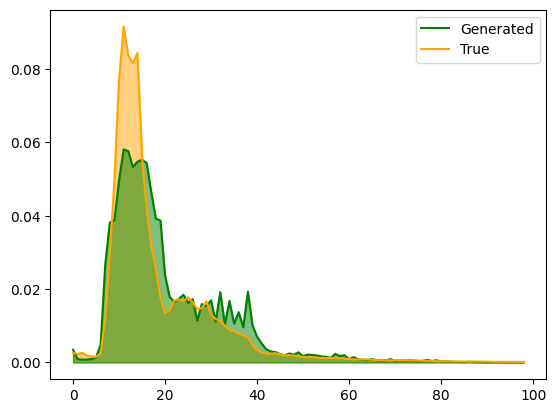

In [93]:
Eval.KLD_TrueGen(SecDataType ='CONDIN',  AnalSig=AnalData[0]) 

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [69]:
FreqID = 10
zVal = Eval.PostSamp[FreqID][0]['TrackZs']
zVals = np.repeat(zVal, N_Gen, axis=0)

In [106]:
FreqLabelCond.shape

(300,)

C:\Users\USER\AppData\Local\Temp\ipykernel_22384\1655678937.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


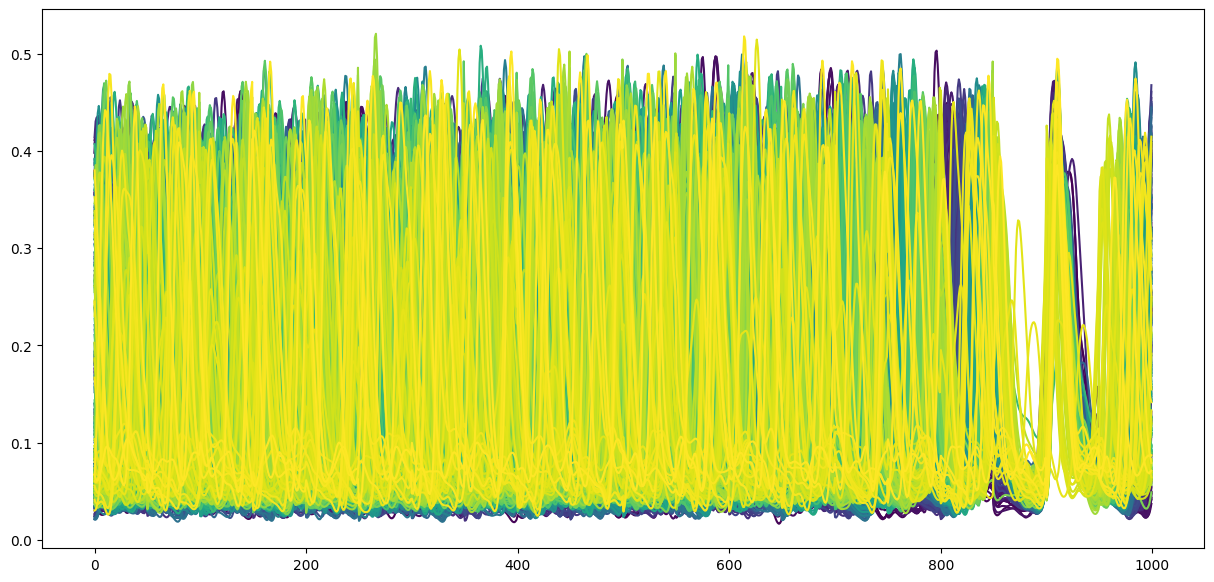

In [70]:
N_Gen=300
SelTruePSD = AnalData[1][np.random.choice(AnalData[1].shape[0], 300, replace=False), :]
FreqLabelCond = np.argmax(SelTruePSD, axis=1)
TruePSD_Sort = SelTruePSD[np.argsort(FreqLabelCond)]
SigGen = GenModel([zVals, TruePSD_Sort])


MinFreqR = 0.01
MaxFreqR = 0.1

# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Gen-1)
norm2 = plt.Normalize(MinFreqR, MaxFreqR)


fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Gen):
    color = cmap(norm(i))
    ax.plot(SigGen[i], color=color)




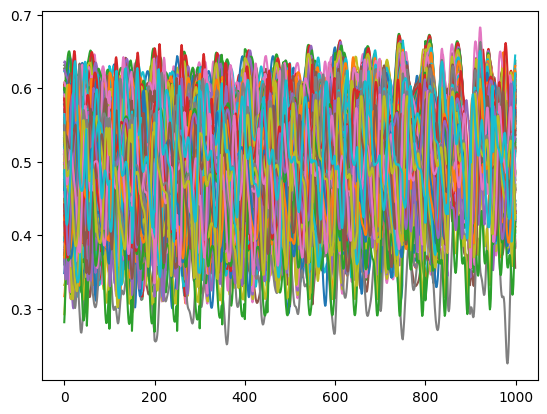

In [86]:
for i in range (N_Gen):
    plt.plot(GenModel([Eval.PostSamp[1][0]['TrackZs'], TruePSD_Sort[i:i+1]])[0])
    